# Full Sherpa test for marginalization setup

## Fitting rl, flux and epoch

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G

os.chdir('../')
from config import CONFIG_INI
from limb_darkening import limb_dark_fit
import margmodule as marg

from sherpa.data import Data1D
from sherpa.plot import DataPlot
from sherpa.plot import ModelPlot
from sherpa.fit import Fit
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar
from sherpa.stats import Chi2
from sherpa.plot import FitPlot

### Set up data paths

In [2]:
localDir = CONFIG_INI.get('data_paths', 'local_path')
outDir = os.path.join(localDir, CONFIG_INI.get('data_paths', 'output_path'))
curr_model = CONFIG_INI.get('data_paths', 'current_model')
dataDir = os.path.join(localDir, os.path.join(localDir, CONFIG_INI.get('data_paths', 'data_path')), curr_model)

### Read in data

In [3]:
# Read in the txt file for the lightcurve data
x, y, err, sh = np.loadtxt(os.path.join(dataDir, 'W17_white_lightcurve_test_data.txt'), skiprows=7, unpack=True)
wavelength = np.loadtxt(os.path.join(dataDir, 'W17_wavelength_test_data.txt'), skiprows=3)

tzero = x[0]
flux0 = y[0]

print("x.shape: {}".format(x.shape))
print("y.shape: {}".format(y.shape))
print("err.shape: {}".format(err.shape))
print("sh.shape: {}".format(sh.shape))
print("wvln.shape: {}".format(wavelength.shape))

x.shape: (51,)
y.shape: (51,)
err.shape: (51,)
sh.shape: (51,)
wvln.shape: (115,)


### Read and set up planet parameters

Not importing `rl`, `epoch`, `inclin`, `ecc`, `omega` and `Per` sinc they will be read by the model directly from the configfile.

Actually, I do need to import `Per` because I need it for the calculation of MsMpR.

In [4]:
Per = CONFIG_INI.getfloat('planet_parameters', 'Per') * u.d
Per = Per.to(u.s)
constant1 = ((G * np.square(Per)) / (4 * np.square(np.pi))) ** (1 / 3)
aor = CONFIG_INI.getfloat('planet_parameters', 'aor')    # this is unitless -> "distance of the planet from the star (meters)/stellar radius (meters)"
MsMpR = (aor / constant1) ** 3.
print("MsMpR: {}".format(MsMpR))

MsMpR: 2013.6545130315214 kg / m3


### Systematic model parameters

The starting parameters for the systematic models are all 0 by default, hence I am not setting them here explicitly.

### Limb darkening

In [5]:
# Limb darkening
M_H = CONFIG_INI.getfloat('limb_darkening', 'metallicity')    # metallicity
Teff = CONFIG_INI.getfloat('limb_darkening', 'Teff')   # effective temperature
logg = CONFIG_INI.getfloat('limb_darkening', 'logg')   # log(g), gravity

# Define limb darkening directory, which is inside this package
limbDir = os.path.join('..', 'Limb-darkening')
ld_model = CONFIG_INI.get('limb_darkening', 'ld_model')
grat = CONFIG_INI.get('technical_parameters', 'grating')
_uLD, c1, c2, c3, c4, _cp1, _cp2, _cp3, _cp4, _aLD, _bLD = limb_dark_fit(grat, wavelength, M_H,
                                                                         Teff, logg, limbDir, ld_model)
print("\nThe four cs: {}, {}, {}, {}".format(c1, c2, c3, c4))

You are using the 3D limb darkening models.
Current Directories Entered:
  ../Limb-darkening
  ../Limb-darkening/3DGrid
Filename: mmu_t65g45m10v05.flx

Closest values to your inputs:
Teff:  6500
M_H:  -1.0
log(g):  4.5

Limb darkening parameters:
4param 	0.87943740	-0.75690632	0.56316819	-0.17285109
3param 	2.18170435	-3.13702297	1.39277902
Quad 	0.03258950	0.35826185
Linear 	0.33642864

The four cs: 0.8794374046913269, -0.7569063175194662, 0.5631681864067452, -0.17285109276089056


### Select systematic grid

For testing purposes, I will only pick one of them and I will set it by hand so that we know what is going on.

In [6]:
# p0 =          [0,    1,     2,      3,     4,    5,    6,    7,  8,  9,  10, 11, 12,  13,    14,    15,    16,    17,     18,      19,      20,      21   ]
# p0 = np.array([rl, flux0, epoch, inclin, MsMpR, ecc, omega, Per, T0, c1, c2, c3, c4, m_fac, HSTP1, HSTP2, HSTP3, HSTP4, xshift1, xshift2, xshift3, xshift4])
nparams = 22
# 1 in the grid means the parameter is fixed, 0 means it is free.
systematics = np.ones((nparams))
# Choice of rl, flux and epoch free
systematics[0] = 0
systematics[1] = 0
systematics[2] = 0

print("Systematics: {}".format(systematics))

Systematics: [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Set up Sherpa data object

In [7]:
# Instantiate a data object
data = Data1D('Data', x, y, staterror=err)
print(data)

name      = Data
x         = Float64[51]
y         = Float64[51]
staterror = Float64[51]
syserror  = None


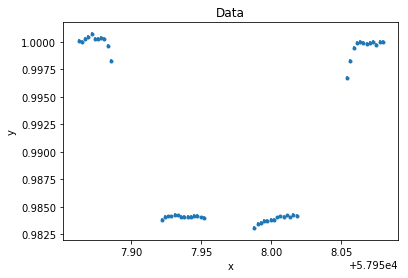

In [8]:
# Plot the data with Sherpa
dplot = DataPlot()
dplot.prepare(data)
dplot.plot() 

### Set up Sherpa model object

In [9]:
# Define the model
tmodel = marg.Transit(tzero, MsMpR, c1, c2, c3, c4, flux0, name="testmodel", sh=sh)
print(tmodel)

testmodel
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   testmodel.rl thawed         0.12 -3.40282e+38  3.40282e+38           
   testmodel.flux thawed      1.00007 -3.40282e+38  3.40282e+38           
   testmodel.epoch thawed        57958 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.inclin thawed      1.52448 -3.40282e+38  3.40282e+38    radians
   testmodel.msmpr thawed      2013.65 -3.40282e+38  3.40282e+38           
   testmodel.ecc thawed            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.omega frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.period frozen      3.73549 -3.40282e+38  3.40282e+38       days
   testmodel.tzero frozen      57957.9 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.c1 frozen     0.879437 -3.40282e+38  3.40282e+38           
   testmodel.c2 frozen    -0.756906 -3.40282e+38  3.40282e+38           
   testmodel.c3 fr

### Freeze some parameters

Most parameters are currently thawed by default. `omega`, `period`, `tzero` and all the limb darkening parameters `c1`-`c4` have `alwaysfrozen=True` in the class, so that we don't have to explicitly set them to frozen every time. And we'll still need the systematics grid to loop through the different systematic models, but I am leaving that out for now.

In [10]:
# Freeze all but rl, flux and epoch
tmodel.epoch.frozen = False
tmodel.inclin.frozen = True
tmodel.msmpr.frozen = True
tmodel.ecc.frozen = True
tmodel.m_fac.frozen = True
tmodel.hstp1.frozen = True
tmodel.hstp2.frozen = True
tmodel.hstp3.frozen = True
tmodel.hstp4.frozen = True
tmodel.xshift1.frozen = True
tmodel.xshift2.frozen = True
tmodel.xshift3.frozen = True
tmodel.xshift4.frozen = True

print(tmodel)

testmodel
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   testmodel.rl thawed         0.12 -3.40282e+38  3.40282e+38           
   testmodel.flux thawed      1.00007 -3.40282e+38  3.40282e+38           
   testmodel.epoch thawed        57958 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.inclin frozen      1.52448 -3.40282e+38  3.40282e+38    radians
   testmodel.msmpr frozen      2013.65 -3.40282e+38  3.40282e+38           
   testmodel.ecc frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.omega frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.period frozen      3.73549 -3.40282e+38  3.40282e+38       days
   testmodel.tzero frozen      57957.9 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.c1 frozen     0.879437 -3.40282e+38  3.40282e+38           
   testmodel.c2 frozen    -0.756906 -3.40282e+38  3.40282e+38           
   testmodel.c3 fr

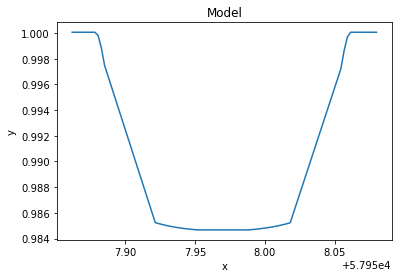

In [11]:
# Plot the model
mplot = ModelPlot()
mplot.prepare(data, tmodel)
mplot.plot()

Turns out there are different ways of evaluating a model on an arbitrary grid, check out:  
https://sherpa.readthedocs.io/en/4.11.0/evaluation/examples.html#examples

### Set up statistics and optimizer

In [27]:
stat = Chi2()
opt = LevMar()

### Set up fit model and make the fit

In [26]:
tfit = Fit(data, tmodel, stat=stat, method=opt)    # Instantiate fit object
tres = tfit.fit()     # do the fit
print(tres)

if not tres.succeeded: print(tres.message)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = leastsq
succeeded      = True
parnames       = ('testmodel.rl', 'testmodel.flux', 'testmodel.epoch')
parvals        = (0.12, 1.00006655, 57957.97)
statval        = 2.8746955897074862e-05
istatval       = 2.8746955897074862e-05
dstatval       = 0.0
numpoints      = 51
dof            = 48
qval           = None
rstat          = None
message        = successful termination
nfev           = 7


In the row `parvals`, we can see that a high number precision is given when dealing with the data. This means that when we see less digits in some of the displays, that will only be becuase of pretty printing.

We can also display the results in a formatted way:

In [14]:
print(tres.format())

Method                = levmar
Statistic             = chi2
Initial fit statistic = 1000.97
Final fit statistic   = 1000.97 at function evaluation 7
Data points           = 51
Degrees of freedom    = 48
Probability [Q-value] = 2.17218e-178
Reduced statistic     = 20.8535
Change in statistic   = 0
   testmodel.rl   0.12         +/- 0.00287979  
   testmodel.flux   1.00007      +/- 4.12925e-05 
   testmodel.epoch   57958        +/- 0.937181    


### Plot fit over data

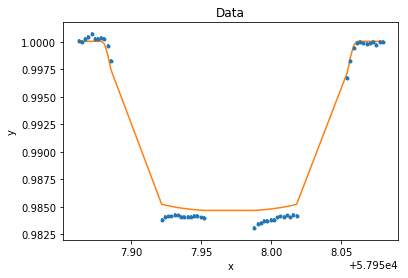

In [15]:
# Plot fit over data
fplot = FitPlot()
mplot.prepare(data, tmodel)
fplot.prepare(dplot, mplot)
fplot.plot()

### Error analysis

The default error estimation analysis method is `covariance`.

In [16]:
print(tfit.estmethod)

name        = covariance
sigma       = 1
eps         = 0.01
maxiters    = 200
soft_limits = False


In [17]:
# Run the error analysis
errors = tfit.est_errors()

In [18]:
# Display the errors
print(errors.format())

Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   testmodel.rl         0.12 -6.78028e-05  6.78028e-05
   testmodel.flux      1.00007  -1.2721e-05   1.2721e-05
   testmodel.epoch        57958        -----        -----


This calculates the one-sigma (68.3%) limits for each thawed parameter and the error range can be changed with the `sigma` parameter (https://sherpa.readthedocs.io/en/4.11.0/fit/index.html#changing-the-error-bounds).

We can directly access the errors:

In [19]:
# Just showing the full (unformatted) output
print(errors)

datasets    = None
methodname  = covariance
iterfitname = none
fitname     = levmar
statname    = chi2
sigma       = 1
percent     = 68.26894921370858
parnames    = ('testmodel.rl', 'testmodel.flux', 'testmodel.epoch')
parvals     = (0.12, 1.00006655, 57957.97)
parmins     = (-6.780279635483041e-05, -1.2720981470999137e-05, None)
parmaxes    = (6.780279635483041e-05, 1.2720981470999137e-05, None)
nfits       = 0


In [20]:
# Access the errors in dictionary
dvals = zip(errors.parnames, errors.parvals, errors.parmins,
errors.parmaxes)
pvals = {d[0]: {'val': d[1], 'min': d[2], 'max': d[3]} for d in dvals}

print(pvals['testmodel.epoch'])

{'val': 57957.97, 'min': None, 'max': None}


In order to save time, we an restrict the error calculation to only the paremeters we need:

In [21]:
rl_err = tfit.est_errors(parlist=(tmodel.rl,))
print(rl_err)

datasets    = None
methodname  = covariance
iterfitname = none
fitname     = levmar
statname    = chi2
sigma       = 1
percent     = 68.26894921370858
parnames    = ('testmodel.rl',)
parvals     = (0.12,)
parmins     = (-6.780279635483041e-05,)
parmaxes    = (6.780279635483041e-05,)
nfits       = 0


More on errors, also on how to investigate error surfaces or do contour plots is described here:  
https://sherpa.readthedocs.io/en/4.11.0/quick.html#error-analysis  
and here:  
https://sherpa.readthedocs.io/en/4.11.0/fit/index.html#estimating-errors

## Results for thawed rl, flux and epoch

Lets print the value and error results for the fitting of `rl` and `flux`, so that we can compare them with the IDL results.

In [22]:
ans = dict(zip(tres.parnames, tres.parvals))

print('rl after fit:')
print(pvals['testmodel.rl'])

print('\nflux after fit:')
print(pvals['testmodel.flux'])

print('\nepoch after fit:')
print(pvals['testmodel.epoch'])

rl after fit:
{'val': 0.12, 'min': -6.780279635483041e-05, 'max': 6.780279635483041e-05}

flux after fit:
{'val': 1.00006655, 'min': -1.2720981470999137e-05, 'max': 1.2720981470999137e-05}

epoch after fit:
{'val': 57957.97, 'min': None, 'max': None}


### Resetting the model parameters

In [23]:
print(tmodel)

testmodel
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   testmodel.rl thawed         0.12 -3.40282e+38  3.40282e+38           
   testmodel.flux thawed      1.00007 -3.40282e+38  3.40282e+38           
   testmodel.epoch thawed        57958 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.inclin frozen      1.52448 -3.40282e+38  3.40282e+38    radians
   testmodel.msmpr frozen      2013.65 -3.40282e+38  3.40282e+38           
   testmodel.ecc frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.omega frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.period frozen      3.73549 -3.40282e+38  3.40282e+38       days
   testmodel.tzero frozen      57957.9 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.c1 frozen     0.879437 -3.40282e+38  3.40282e+38           
   testmodel.c2 frozen    -0.756906 -3.40282e+38  3.40282e+38           
   testmodel.c3 fr

We can reset the model parameters to their initial values.

In [24]:
tmodel.reset()
print(tmodel)

testmodel
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   testmodel.rl thawed         0.12 -3.40282e+38  3.40282e+38           
   testmodel.flux thawed      1.00007 -3.40282e+38  3.40282e+38           
   testmodel.epoch thawed        57958 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.inclin frozen      1.52448 -3.40282e+38  3.40282e+38    radians
   testmodel.msmpr frozen      2013.65 -3.40282e+38  3.40282e+38           
   testmodel.ecc frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.omega frozen            0 -3.40282e+38  3.40282e+38    degrees
   testmodel.period frozen      3.73549 -3.40282e+38  3.40282e+38       days
   testmodel.tzero frozen      57957.9 -3.40282e+38  3.40282e+38 days [MJD]
   testmodel.c1 frozen     0.879437 -3.40282e+38  3.40282e+38           
   testmodel.c2 frozen    -0.756906 -3.40282e+38  3.40282e+38           
   testmodel.c3 fr